# Visualize pymoo result
Load the pymoo result object saved with pickle and visualize it.

ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [1]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj3: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

### Load rvea results for all topos

In [2]:
with open('res_bc_Cogent_rvea.pkl','rb') as f_Cogent:
    res_7_Cogent = pickle.load(f_Cogent)
with open('res_bc_UsCarrier_rvea.pkl','rb') as f_UsCarrier:
    res_7_UsCarrier = pickle.load(f_UsCarrier)
with open('res_bc_HiberniaGlobal_rvea.pkl','rb') as f_HiberniaGlobal:
    res_7_HiberniaGlobal = pickle.load(f_HiberniaGlobal)
with open('res_bc_Colt_rvea.pkl','rb') as f_Colt:
    res_7_Colt = pickle.load(f_Colt)
with open('res_bc_Funet_rvea.pkl','rb') as f_Funet:
    res_7_Funet = pickle.load(f_Funet)
with open('res_bc_Abvt_rvea.pkl','rb') as f_Abvt:
    res_7_Abvt = pickle.load(f_Abvt)
with open('res_bc_Intellifiber_rvea.pkl','rb') as f_Intellifiber:
    res_7_Intellifiber = pickle.load(f_Intellifiber)
with open('res_bc_TataNld_rvea.pkl','rb') as f_TataNld:
    res_7_TataNld = pickle.load(f_TataNld)
with open('res_bc_Internode_rvea.pkl','rb') as f_Internode:
    res_7_Internode = pickle.load(f_Internode)
with open('res_bc_Missouri_rvea.pkl','rb') as f_Missouri:
    res_7_Missouri = pickle.load(f_Missouri)
with open('res_bc_Ion_rvea.pkl','rb') as f_Ion:
    res_7_Ion = pickle.load(f_Ion)
with open('res_bc_Palmetto_rvea.pkl','rb') as f_Palmetto:
    res_7_Palmetto = pickle.load(f_Palmetto)

## Hypervolume
1. Store values

In [3]:
# rvea
F7_Cogent=res_7_Cogent.F
F7_UsCarrier=res_7_UsCarrier.F
F7_HiberniaGlobal=res_7_HiberniaGlobal.F
F7_Colt=res_7_Colt.F
F7_Funet=res_7_Funet.F
F7_Abvt=res_7_Abvt.F
F7_Intellifiber=res_7_Intellifiber.F
F7_TataNld=res_7_TataNld.F
F7_Internode=res_7_Internode.F
F7_Missouri=res_7_Missouri.F
F7_Ion=res_7_Ion.F
F7_Palmetto=res_7_Palmetto.F

# # Nadir Point from 9 Algorithms: 
# ref_point = [1.81000000e+02 6.20000000e+01 3.92281875e+03 1.70537209e+00]
# # Nadir Point from 4 Algorithms: 
# ref_point = [160.  77.  inf  inf]
# # Nadir Point from all (13) Algorithms: 
# ref_point = [181.  77.  inf  inf]

ref_point = [181, 77, 3922.81875, 1.70537209]

hist_F7_Cogent = []
hist_F7_UsCarrier = []
hist_F7_HiberniaGlobal = []
hist_F7_Colt = []
hist_F7_Funet = []
hist_F7_Abvt = []
hist_F7_Intellifiber = []
hist_F7_TataNld = []
hist_F7_Internode = []
hist_F7_Missouri = []
hist_F7_Ion = []
hist_F7_Palmetto = []


for algo7_Cogent in res_7_Cogent.history:
    opt7_Cogent = algo7_Cogent.opt
    feas7_Cogent = np.where(opt7_Cogent.get("feasible"))[0]
    hist_F7_Cogent.append(opt7_Cogent.get("F")[feas7_Cogent])
for algo7_UsCarrier in res_7_UsCarrier.history:
    opt7_UsCarrier = algo7_UsCarrier.opt
    feas7_UsCarrier = np.where(opt7_UsCarrier.get("feasible"))[0]
    hist_F7_UsCarrier.append(opt7_UsCarrier.get("F")[feas7_UsCarrier])
for algo7_HiberniaGlobal in res_7_HiberniaGlobal.history:
    opt7_HiberniaGlobal = algo7_HiberniaGlobal.opt
    feas7_HiberniaGlobal = np.where(opt7_HiberniaGlobal.get("feasible"))[0]
    hist_F7_HiberniaGlobal.append(opt7_HiberniaGlobal.get("F")[feas7_HiberniaGlobal])
for algo7_Colt in res_7_Colt.history:
    opt7_Colt = algo7_Colt.opt
    feas7_Colt = np.where(opt7_Colt.get("feasible"))[0]
    hist_F7_Colt.append(opt7_Colt.get("F")[feas7_Colt])
for algo7_Funet in res_7_Funet.history:
    opt7_Funet = algo7_Funet.opt
    feas7_Funet = np.where(opt7_Funet.get("feasible"))[0]
    hist_F7_Funet.append(opt7_Funet.get("F")[feas7_Funet])
for algo7_Abvt in res_7_Abvt.history:
    opt7_Abvt = algo7_Abvt.opt
    feas7_Abvt = np.where(opt7_Abvt.get("feasible"))[0]
    hist_F7_Abvt.append(opt7_Abvt.get("F")[feas7_Abvt])
for algo7_Intellifiber in res_7_Intellifiber.history:
    opt7_Intellifiber = algo7_Intellifiber.opt
    feas7_Intellifiber = np.where(opt7_Intellifiber.get("feasible"))[0]
    hist_F7_Intellifiber.append(opt7_Intellifiber.get("F")[feas7_Intellifiber])
for algo7_TataNld in res_7_TataNld.history:
    opt7_TataNld = algo7_TataNld.opt
    feas7_TataNld = np.where(opt7_TataNld.get("feasible"))[0]
    hist_F7_TataNld.append(opt7_TataNld.get("F")[feas7_TataNld])
for algo7_Internode in res_7_Internode.history:
    opt7_Internode = algo7_Internode.opt
    feas7_Internode= np.where(opt7_Internode.get("feasible"))[0]
    hist_F7_Internode.append(opt7_Internode.get("F")[feas7_Internode])
for algo7_Missouri in res_7_Missouri.history:
    opt7_Missouri = algo7_Missouri.opt
    feas7_Missouri = np.where(opt7_Missouri.get("feasible"))[0]
    hist_F7_Missouri.append(opt7_Missouri.get("F")[feas7_Missouri])
for algo7_Ion in res_7_Ion.history:
    opt7_Ion = algo7_Ion.opt
    feas7_Ion = np.where(opt7_Ion.get("feasible"))[0]
    hist_F7_Ion.append(opt7_Ion.get("F")[feas7_Ion])
for algo7_Palmetto in res_7_Palmetto.history:
    opt7_Palmetto = algo7_Palmetto.opt
    feas7_Palmetto = np.where(opt7_Palmetto.get("feasible"))[0]
    hist_F7_Palmetto.append(opt7_Palmetto.get("F")[feas7_Palmetto])

2. Calculate hypervolume and merge them (Mean value) for rvea algorithm

In [4]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array(ref_point))

hv_7_Cogent = [metric.do(_F7_Cogent) for _F7_Cogent in hist_F7_Cogent]
hv_7_UsCarrier = [metric.do(_F7_UsCarrier) for _F7_UsCarrier in hist_F7_UsCarrier]
hv_7_HiberniaGlobal = [metric.do(_F7_HiberniaGlobal) for _F7_HiberniaGlobal in hist_F7_HiberniaGlobal]
hv_7_Colt = [metric.do(_F7_Colt) for _F7_Colt in hist_F7_Colt]
hv_7_Funet = [metric.do(_F7_Funet) for _F7_Funet in hist_F7_Funet]
hv_7_Abvt = [metric.do(_F7_Abvt) for _F7_Abvt in hist_F7_Abvt]
hv_7_Intellifiber = [metric.do(_F7_Intellifiber) for _F7_Intellifiber in hist_F7_Intellifiber]
hv_7_TataNld = [metric.do(_F7_TataNld) for _F7_TataNld in hist_F7_TataNld]
hv_7_Internode = [metric.do(_F7_Internode) for _F7_Internode in hist_F7_Internode]
hv_7_Missouri = [metric.do(_F7_Missouri) for _F7_Missouri in hist_F7_Missouri]
hv_7_Ion = [metric.do(_F7_Ion) for _F7_Ion in hist_F7_Ion]
hv_7_Palmetto = [metric.do(_F7_Palmetto) for _F7_Palmetto in hist_F7_Palmetto]

# rvea
hv_7 = [(hv_Cogent + hv_UsCarrier + hv_HiberniaGlobal + hv_Colt + hv_Funet + hv_Abvt + hv_Intellifiber + hv_TataNld + hv_Internode + hv_Missouri + hv_Ion + hv_Palmetto) / 12 for hv_Cogent, hv_UsCarrier, hv_HiberniaGlobal, hv_Colt, hv_Funet, hv_Abvt, hv_Intellifiber, hv_TataNld, hv_Internode, hv_Missouri, hv_Ion, hv_Palmetto in zip(hv_7_Cogent, hv_7_UsCarrier, hv_7_HiberniaGlobal, hv_7_Colt, hv_7_Funet, hv_7_Abvt, hv_7_Intellifiber, hv_7_TataNld, hv_7_Internode, hv_7_Missouri, hv_7_Ion, hv_7_Palmetto)]

The hypervolumn for Cogent:
[0.0, 0.0, 480739.7164795165, 4781747.459502637, 3108742.63439114, 3810060.547488388, 6284911.796379392, 6361501.71973274, 8412134.723131005, 8059444.463937768, 9086436.565842547, 10297571.866420118, 11022614.934271831, 13432143.742510641, 13566138.063953366, 14278690.452692077, 13818827.605827482, 14450229.425334139, 14765759.06268176, 16179914.759922685, 16220848.657778947, 16425712.940984001, 17246159.62061366, 17268676.291835602, 16701064.28262549, 17332106.839102756, 18817814.979084138, 19547915.883659504, 20446729.567666102, 21813291.619393427, 22032202.399528746, 22857219.20708265, 22724852.751233686, 22928201.554460365, 24478842.147871207, 25146675.12387671, 24542792.658096604, 25293006.00435136, 26349254.752124935, 27044743.94210381, 26945202.052265875, 27678628.089925773, 29132573.845409475, 29429217.699968185, 30895794.397787083, 31620551.925837867, 32368834.845906194, 32407304.091362413, 32924348.365964055, 33621534.71056693, 33699106.4511332, 35

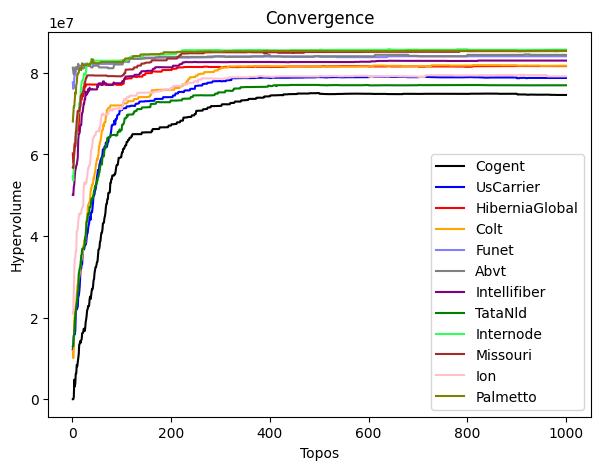

In [5]:
print('The hypervolumn for Cogent:')
print(hv_7_Cogent)
print('The hypervolumn for UsCarrier:')
print(hv_7_UsCarrier)
print('The hypervolumn for HiberniaGlobal:')
print(hv_7_HiberniaGlobal)
print('The hypervolumn for Colt:')
print(hv_7_Colt)
print('The hypervolumn for Funet:')
print(hv_7_Funet)
print('The hypervolumn for Abvt:')
print(hv_7_Abvt)
print('The hypervolumn for Intellifiber:')
print(hv_7_Intellifiber)
print('The hypervolumn for TataNld:')
print(hv_7_TataNld)
print('The hypervolumn for Internode:')
print(hv_7_Internode)
print('The hypervolumn for Missouri:')
print(hv_7_Missouri)
print('The hypervolumn for Ion:')
print(hv_7_Ion)
print('The hypervolumn for Palmetto:')
print(hv_7_Palmetto)

# Show all hv for each topo
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_7_Cogent)+1)), hv_7_Cogent,  color='black', label='Cogent')
plt.plot(list(range(1, len(hv_7_UsCarrier)+1)), hv_7_UsCarrier,  color='blue', label='UsCarrier')
plt.plot(list(range(1, len(hv_7_HiberniaGlobal)+1)), hv_7_HiberniaGlobal,  color='red', label='HiberniaGlobal')
plt.plot(list(range(1, len(hv_7_Colt)+1)), hv_7_Colt,  color='orange', label='Colt')
plt.plot(list(range(1, len(hv_7_Funet)+1)), hv_7_Funet,  color=(0, 0, 1, 0.5), label='Funet')
plt.plot(list(range(1, len(hv_7_Abvt)+1)), hv_7_Abvt,  color='gray', label='Abvt')
plt.plot(list(range(1, len(hv_7_Intellifiber)+1)), hv_7_Intellifiber,  color='purple', label='Intellifiber')
plt.plot(list(range(1, len(hv_7_TataNld)+1)), hv_7_TataNld,  color='green', label='TataNld')
plt.plot(list(range(1, len(hv_7_Internode)+1)), hv_7_Internode,  color='#33FF57', label='Internode')
plt.plot(list(range(1, len(hv_7_Missouri)+1)), hv_7_Missouri,  color='brown', label='Missouri')
plt.plot(list(range(1, len(hv_7_Ion)+1)), hv_7_Ion,  color='pink', label='Ion')
plt.plot(list(range(1, len(hv_7_Palmetto)+1)), hv_7_Palmetto,  color='olive', label='Palmetto')
plt.title("Convergence")
plt.xlabel("Topos")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

In [6]:
print('The aveage of hypervolumn for rvea:')
print(hv_7)

The aveage of hypervolumn for rvea:
[42210066.92352531, 41898099.54507243, 44030792.285422206, 46191216.73450912, 47314796.6661723, 47991769.34142154, 49600312.43344599, 50286414.207756825, 51488326.350362696, 52160094.79641887, 52970766.23685518, 53999735.455424, 54774105.798404574, 55635074.320310175, 56195358.74188218, 56770290.95091268, 57646712.26558895, 58022729.131064594, 58651881.03448456, 59274681.18390465, 59599318.088674426, 59871573.040503085, 60784823.19128611, 61025379.821789324, 61478479.652726404, 61654572.52406033, 62095079.35533898, 62704695.0013682, 63359935.21472045, 63742396.63797092, 64049741.34397474, 64562664.64419944, 64560834.12904457, 64749338.48346273, 65212752.16520942, 65324662.223784566, 65533504.870509446, 66112294.113355994, 66364905.28765147, 66567847.26228386, 66738155.590016365, 67038999.54497724, 67450364.99429166, 67538225.03557922, 67851245.95113581, 68086071.11774756, 68243879.0552537, 68504033.19493242, 68670177.81807469, 68989538.3074218, 69127

3. Draw mean hypervolume for rvea

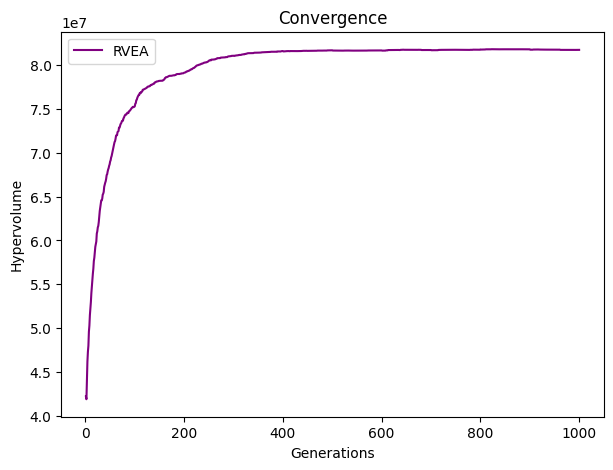

In [7]:
import matplotlib.pyplot as plt

#  Show all alogrithms' hv into a single figure
plt.figure(figsize=(7, 5))
# plt.plot(list(range(1, len(hv_1)+1)), hv_1,  color='black', label='AGEMOEA')
# plt.plot(list(range(1, len(hv_2)+1)), hv_2,  color='blue', label='AGEMOEA2')
# plt.plot(list(range(1, len(hv_3)+1)), hv_3,  color='red', label='NSGA2')
# plt.plot(list(range(1, len(hv_4)+1)), hv_4,  color='orange', label='NSGA3')
# plt.plot(list(range(1, len(hv_5)+1)), hv_5,  color=(0, 0, 1, 0.5), label='RNSGA2')
# plt.plot(list(range(1, len(hv_6)+1)), hv_6,  color='gray', label='RNSGA3')
plt.plot(list(range(1, len(hv_7)+1)), hv_7,  color='purple', label='RVEA')
# plt.plot(list(range(1, len(hv_8)+1)), hv_8,  color='green', label='SMSEMOA')
# plt.plot(list(range(1, len(hv_9)+1)), hv_9,  color='#33FF57', label='UNSGA3')
# plt.plot(list(range(1, len(hv_10)+1)), hv_10,  color='brown', label='CTAEA')
# plt.plot(list(range(1, len(hv_11)+1)), hv_11,  color='pink', label='DNSGA2')
# plt.plot(list(range(1, len(hv_12)+1)), hv_12,  color='olive', label='KGBDMOEA')
# plt.plot(list(range(1, len(hv_13)+1)), hv_13,  color='cyan', label='MOEAD')
plt.title("Convergence")
plt.xlabel("Generations") # brown,pink,#5733FF,olive,cyan,#FF5733,#33FF57
plt.ylabel("Hypervolume")
plt.legend()
plt.show()